In [1]:
## goal:
## get something working here... with the heavily reduced image sizes
## then get it into ec2


## TODOS: (just for this section)
### SETUP for dice coefficient --> what will the cost function be here?
### SETUP run length encoding?
### SETUP image rescaler? if train on scaled images then need to rescale output then get run length encoded values


In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import imread

In [14]:
a_mask = imread('data/train_scaled/10_1_mask.png')
a = imread('data/train_scaled/10_1.png')

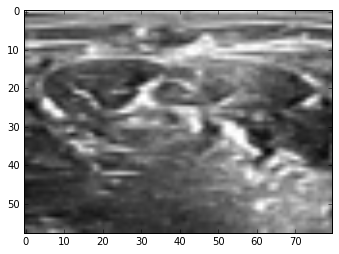

In [15]:
plt.imshow(a, cmap=plt.cm.gray)

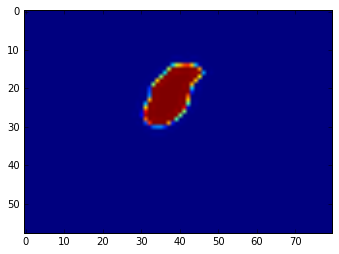

In [16]:
plt.imshow(a_mask)

In [18]:
## how to read all of these:
### need to extract the file name and if it is a mask?
## so that they can be matched

In [159]:
from glob import glob
from os.path import basename
from keras.utils import np_utils ## not using currently - don't understand categorical requirement???
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

In [161]:
## read training data

## code from https://www.kaggle.com/zfturbo/ultrasound-nerve-segmentation/keras-is-there-any-nerve/code
## author -- zfturbo

X_train = []
X_train_id = []
mask_train = []
files = glob('data/train_scaled/*[0-9].png')
for file in files:
    file_basename = basename(file)
    X_train.append(imread(file))
    image_id = file_basename[:-4]
    X_train_id.append(image_id)
    mask_file = 'data/train_scaled/' + image_id + '_mask.png'
    mask_train.append(imread(mask_file))
    
nrows, ncols = X_train[0].shape
train_data = np.array(X_train, dtype=np.uint8)
train_target = np.array(mask_train, dtype=np.uint8)
train_data = train_data.reshape(train_data.shape[0], 1, nrows, ncols)

train_target = (train_target != 0).astype(np.uint8)
train_data = train_data.astype('float32')
train_data /= 255
print('Train shape:', train_data.shape)
print(train_data.shape[0], 'train samples')

Train shape: (5635, 1, 58, 80)
5635 train samples


In [162]:
train_target = np_utils.to_categorical(train_target, 2)

In [163]:
## load test data

In [164]:
train_data[0].shape

(1, 58, 80)

In [165]:
## try some model??
def create_model(nrows, ncols):
    model = Sequential()
    model.add(Convolution2D(4, 3, 3, border_mode='same', init='he_normal',
                            input_shape=(1, nrows, ncols)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Convolution2D(8, 3, 3, border_mode='same', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(2))
    model.add(Activation('softmax'))

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [166]:
batch_size = 32
nb_epoch = 50
random_state = 51
n_folds = 3

In [167]:
kf = KFold(len(train_data), n_folds=n_folds, shuffle=True, random_state=random_state)
num_fold = 0
sum_score = 0
for train_index, test_index in kf:
    model = create_model(nrows, ncols)
    X_train, X_valid = train_data[train_index], train_data[test_index]
    Y_train, Y_valid = train_target[train_index], train_target[test_index]

    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, n_folds))
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=2, verbose=0),
        ]
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              shuffle=True, verbose=2, validation_data=(X_valid, Y_valid),
              callbacks=callbacks)

    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)

Start KFold number 1 from 3
Split train:  3756 3756
Split valid:  1879 1879
Train on 3756 samples, validate on 1879 samples
Epoch 1/50
4s - loss: 1.0023 - val_loss: 0.8609
Epoch 2/50
5s - loss: 0.8441 - val_loss: 0.9037
Epoch 3/50
5s - loss: 0.8223 - val_loss: 0.8740
Epoch 4/50
5s - loss: 0.8135 - val_loss: 0.8369
Epoch 5/50
5s - loss: 0.8039 - val_loss: 0.8184
Epoch 6/50
5s - loss: 0.7971 - val_loss: 0.8143
Epoch 7/50
4s - loss: 0.7921 - val_loss: 0.8146
Epoch 8/50
5s - loss: 0.7898 - val_loss: 0.8083
Epoch 9/50
5s - loss: 0.7857 - val_loss: 0.8059
Epoch 10/50
4s - loss: 0.7848 - val_loss: 0.8036
Epoch 11/50
4s - loss: 0.7766 - val_loss: 0.8079
Epoch 12/50
4s - loss: 0.7777 - val_loss: 0.8064
Epoch 13/50
4s - loss: 0.7760 - val_loss: 0.8009
Epoch 14/50
4s - loss: 0.7760 - val_loss: 0.8016
Epoch 15/50
4s - loss: 0.7746 - val_loss: 0.8019
Epoch 16/50
4s - loss: 0.7729 - val_loss: 0.7994
Epoch 17/50
4s - loss: 0.7677 - val_loss: 0.7986
Epoch 18/50
4s - loss: 0.7689 - val_loss: 0.7986
Epo